## Installation & Loading Packages

In [ ]:
#@title install packages
!pip install transformers
!pip install transformers[sentencepiece]
!pip install -U sentence-transformers
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install gradio -q #interface
!pip install datasets
#!pip install transformers datasets accelerate nvidia-ml-py3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 14.3 MB/s 
     |████████████████████████████████| 7.6 MB 47.0 MB/s 
     |████████████████████████████████| 163 kB 57.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=10b2e6f57f8daea66a65034b461289ba332e485c92ae6fd045140fc06793ce31
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pub

In [ ]:
#@title Import Packages
import warnings
warnings.filterwarnings("ignore")
import torch.utils.data as data
import torchvision
from torchvision import transforms,datasets, models
from transformers import PegasusForConditionalGeneration, PegasusTokenizer,AutoTokenizer, AutoModel
from transformers import pipeline,TrainingArguments, Trainer, logging
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import requests
from PIL import Image, ImageFont, ImageDraw
from datasets import load_dataset
from datasets import Dataset
import cv2
import glob 
import os  
from os import listdir
import numpy as np
#from pynvml import *
from torchvision.io.image import decode_jpeg, read_file, ImageReadMode, write_jpeg, encode_jpeg, read_image,decode_image
from sentence_transformers import SentenceTransformer, util

In [ ]:
#@title IMC installment
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y9knj3ft
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-y9knj3ft
     |████████████████████████████████| 53 kB 2.0 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=8267bf053c3e2ffadc5e91face0ddb1eabfecdb6837a72b591576f70d8f47c55
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ktqwhn9/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
import os
from huggingface_hub import hf_hub_download
conceptual_weight = hf_hub_download(repo_id="akhaliq/CLIP-prefix-captioning-conceptual-weights", filename="conceptual_weights.pt")
coco_weight = hf_hub_download(repo_id="akhaliq/CLIP-prefix-captioning-COCO-weights", filename="coco_weights.pt")
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
import gradio as gr

Downloading:   0%|          | 0.00/636M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/636M [00:00<?, ?B/s]

In [ ]:


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self
        

#@title Caption Class Define

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]


In [ ]:
#@title Prediction function

is_gpu = False 
device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

def prediction(img):   # def prediction(img,model_name):   
  prefix_length = 10
    
  model = ClipCaptionModel(prefix_length)
  model_path = conceptual_weight
  model.load_state_dict(torch.load(model_path, map_location=CPU)) 
  model = model.eval() 
  device = CUDA(0) if is_gpu else "cpu"
  model = model.to(device)

  use_beam_search = False 
  #image = io.imread(img)
  image=cv2.imread(img)
  pil_image = PIL.Image.fromarray(image)  
  image = preprocess(pil_image).unsqueeze(0).to(device)
  with torch.no_grad():
      prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
      prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
  if use_beam_search:
      generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
  else:
      generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
  return generated_text_prefix

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 209MiB/s]


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

@article{mokady2021clipcap, title={ClipCap: CLIP Prefix for Image Captioning}, author={Mokady, Ron and Hertz, Amir and Bermano, Amit H}, journal={arXiv preprint arXiv:2111.09734}, year={2021} }
https://huggingface.co/spaces/akhaliq/CLIP_prefix_captioning/blob/main/app.py

# image set

load image

In [ ]:
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/conceptual/AD'

/content/drive/MyDrive/conceptual/AD


In [ ]:
dir= '/content/drive/MyDrive/conceptual/AD'

test image-caption

In [ ]:
fileList=os.listdir(dir)
fileList[30]

'图片32.png'

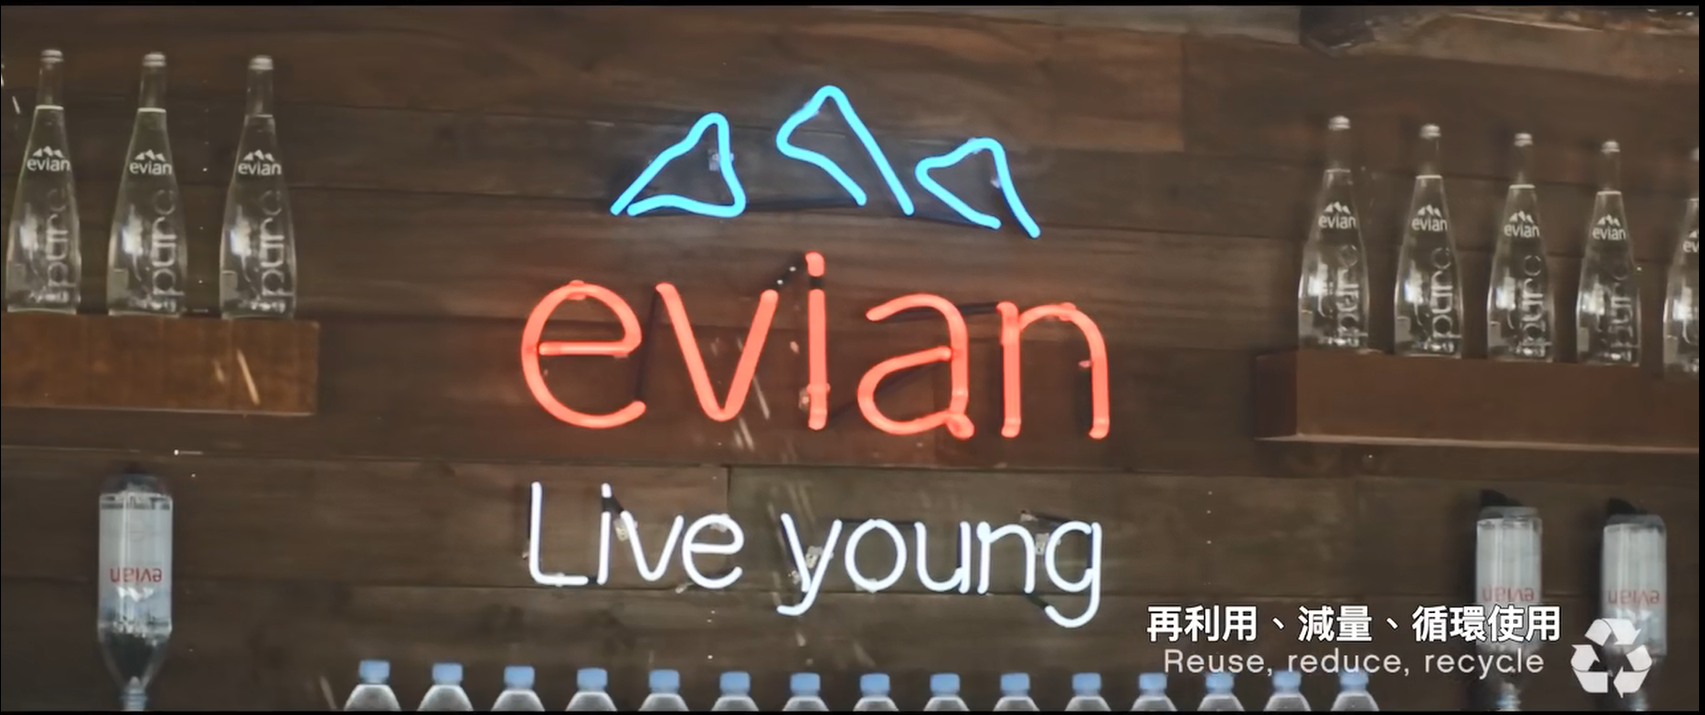

In [ ]:
image = io.imread('图片20.png')
pil_image = PIL.Image.fromarray(image) 
pil_image

In [ ]:
txt=prediction(fileList[20])

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


In [ ]:
txt

'a surfer gets barreled on a small wave.'

#Caption Set Generator

In [ ]:
#Conceptual
def get_image_caption (path):
  
  fileList=os.listdir(path)
  #images =[cv2.imread(file) for file in fileList]
  n=len(fileList)
  text=[]
  for i in range(0,n):
    # image=transform(img)
    if fileList[i] is not None:
      print(i)
      pred=prediction(fileList[i])
      text.append(pred)
    else:
      error=str(os.path.basename(fileList[i]))
      print(error+' '+':'+'is None')
      continue

  return text

In [ ]:
txt3=get_image_caption(dir)

0


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


1


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


2


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


3


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


4


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


5


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


6


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


7


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


8


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


9


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


10


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


11


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


12


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


13


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


14


100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


15


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


16


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


17


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


18


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


19


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


20


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


21


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


22


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


23


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


24


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


25


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


26


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


27


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


28


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


29


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


30


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


31


100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


32


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


In [ ]:
txt3

['waves crash against the rocks.',
 'a close up of the waves.',
 'person, who is known for his love of music, has been dating person.',
 'person is seen in the water.',
 'slow motion shot of a beautiful ocean waves.',
 'actor in a swimming pool.',
 'a man is jumping into the water.',
 'a surfer rides up and down a nice wave.',
 'a surfer gets barreled on a big wave.',
 'the man in the mirror.',
 'a surfer gets barreled on a fast wave.',
 'the shark was spotted by a photographer.',
 'the man in the mask.',
 'a surfer gets towed into the water by a large wave.',
 "the baby's mother, who is also a mother, said she was shocked to see the baby's face.",
 'the new trailer for science fiction film.',
 'the video shows a mother and baby walking on the beach.',
 'a child plays with a toy.',
 'the face of film character.',
 'a woman sits on a beach and looks out to sea.',
 'a surfer gets barreled on a small wave.',
 'a black and white dolphin is being washed by a man.',
 'a man is walking on the

In [ ]:
def text_modifier(text):
  #加个similarity进去:好像没什么必要
  txt=" ".join(text)
  return txt

In [ ]:
txt3_1=text_modifier(txt3)

In [ ]:
txt3_1

"waves crash against the rocks. a close up of the waves. person, who is known for his love of music, has been dating person. person is seen in the water. slow motion shot of a beautiful ocean waves. actor in a swimming pool. a man is jumping into the water. a surfer rides up and down a nice wave. a surfer gets barreled on a big wave. the man in the mirror. a surfer gets barreled on a fast wave. the shark was spotted by a photographer. the man in the mask. a surfer gets towed into the water by a large wave. the baby's mother, who is also a mother, said she was shocked to see the baby's face. the new trailer for science fiction film. the video shows a mother and baby walking on the beach. a child plays with a toy. the face of film character. a woman sits on a beach and looks out to sea. a surfer gets barreled on a small wave. a black and white dolphin is being washed by a man. a man is walking on the beach. the family on the beach. a group of people playing guitar and drums on the beach.

In [ ]:
txt3_2="the game is set to release."

In [ ]:
txt3_3="the family on the beach."

## Summary Generators Test

pegasus-xsum

In [ ]:
txt4='Life is too short to spend time with people who suck the happiness out of you. If someone wants you in their life, they’ll make room for you. You shouldn’t have to fight for a spot. Never, ever insist yourself to someone who continuously overlooks your worth. And remember, it’s not the people that stand by your side when you’re at your best, but the ones who stand beside you when you’re at your worst that are your true friends.'

In [ ]:
txt5='In the flood of darkness, hope is the light. It brings comfort, faith, and confidence. It gives us guidance when we are lost, and gives support when we are afraid. And the moment we give up hope, we give up our lives. The world we live in is disintegrating into a place of malice and hatred, where we need hope and find it harder. In this world of fear, hope to find better, but easier said than done, the more meaningful life of faith will make life meaningful.'

In [ ]:
txt6="Only when you understand the true meaning of life can you live truly. Bittersweet as life is, it's still wonderful, and it's fascinating even in tragedy. If you're just alive, try harder and try to live wonderfully."

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
# Load tokenizer 
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
# Load model 
model_t = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

In [ ]:
tokens = tokenizer(txt3_2, truncation=True, padding="longest", return_tensors="pt")
summary = model_t.generate(**tokens)
tokenizer.decode(summary[0])

'A new trailer has been released for the video game Pokemon Go.'

In [ ]:
tokens = tokenizer(txt3_3, truncation=True, padding="longest", return_tensors="pt")
summary = model_t.generate(**tokens)
tokenizer.decode(summary[0])

'Images courtesy of AFP, EPA, Getty Images and Reuters'

In [ ]:
tokens = tokenizer(txt4, truncation=True, padding="longest", return_tensors="pt")
summary = model_t.generate(**tokens)
tokenizer.decode(summary[0])

'It’s time to move on from the people who make you miserable.'

In [ ]:
tokens = tokenizer(txt5, truncation=True, padding="longest", return_tensors="pt")
summary = model_t.generate(**tokens)
tokenizer.decode(summary[0])

'In the darkness of war, hope is the light.'

bart-large-cnn

In [ ]:
from transformers import pipeline

#google/pegasus-xsum  // pszemraj/led-base-book-summary
# philschmid/bart-large-cnn-samsum / facebook/bart-large-cnn / knkarthick/MEETING_SUMMARY(可)/google/pegasus-multi_news(extract & abstract)
#pszemraj/long-t5-tglobal-base-16384-book-summary（extract）/ sshleifer/distilbart-cnn-12-6 / 

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
print(summarizer(txt5, max_length=100, min_length=10, do_sample=False))

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[{'summary_text': 'The world we live in is disintegrating into a place of malice and hatred, where we need hope and find it harder. In the flood of darkness, hope is the light. It brings comfort, faith, and confidence. It gives us guidance when we are lost. And the moment we give up hope, we giveup our lives.'}]


In [ ]:
print(summarizer(txt3_1, max_length=100, min_length=10, do_sample=False))

[{'summary_text': 'The video shows a mother and baby walking on the beach. waves crash against the rocks. the face of film character.'}]


bart-large-xsum

In [ ]:
from transformers import pipeline

#google/pegasus-xsum  // pszemraj/led-base-book-summary
# philschmid/bart-large-cnn-samsum / facebook/bart-large-cnn / knkarthick/MEETING_SUMMARY(可)/google/pegasus-multi_news(extract & abstract)
#pszemraj/long-t5-tglobal-base-16384-book-summary（extract）/ sshleifer/distilbart-cnn-12-6 / 

summarizer2 = pipeline("summarization", model="facebook/bart-large-xsum")
print(summarizer2(txt5, max_length=100, min_length=7, do_sample=False))

Downloading:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[{'summary_text': 'In our series of letters from African journalists, film-maker and columnist Farai Sevenzo looks at the importance of hope.'}]


In [ ]:
print(summarizer2(txt3_1, max_length=100, min_length=7, do_sample=False))

[{'summary_text': 'A look at some of the most eye-catching images from around the world this week:.'}]
